## <center>RNN forecasting a Sine Wave</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

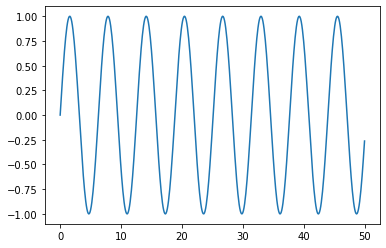

In [3]:
plt.plot(x,y)

Let's turn this into a DataFrame

In [4]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


#### Train Test Split

Note! This is very different from our usual test/train split methodology!

In [5]:
len(df)

501

In [6]:
test_percent = 0.1

In [7]:
len(df)*test_percent

50.1

In [8]:
test_point = np.round(len(df)*test_percent)
test_ind = int(len(df) - test_point)
test_ind

451

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208


In [11]:
test

,Sine
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591
45.6,0.998900
45.7,0.989229
45.8,0.969673
45.9,0.940429
46.0,0.901788


#### Scale Data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In this case, due to the fact that the output of the RNN is inputed again inside the Neural Network, it's important to scale it. 

### Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
length = 2 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch

generator = TimeseriesGenerator(data=scaled_train, # Where is the X
                                targets=scaled_train, # Where is the y
                                length=length, 
                                batch_size=batch_size)

In [16]:
len(scaled_train)

451

In [17]:
len(generator) # n_input = 2

# In this case is 451 - 2 (length)

449

In [18]:
# What does the first batch look like?
X,y = generator[0]

In [19]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.49999912 0.54991622]
Predict this y: 
 [[0.59933458]]


In [20]:
# Let's redefine to get 10 steps back and then predict the next step out
length = 10 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [21]:
# What does the first batch look like?
X,y = generator[0]

In [22]:
len(generator)

441

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.49999912 0.54991622 0.59933458 0.64776041 0.69470985 0.73971381
 0.78232262 0.82211054 0.85868004 0.89166571]
Predict this y: 
 [[0.92073798]]


In [24]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [26]:
# We're only using one feature in our time series
n_features = 1 # We just have x to predict y

In [27]:
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50, input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit model
model.fit_generator(generator,epochs=5)

Epoch 1/5


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13240\2200378995.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=5)


401/401 [==============================] - 3s 7ms/step - loss: 0.0015
Epoch 2/5
401/401 [==============================] - 3s 6ms/step - loss: 1.0378e-04
Epoch 3/5
401/401 [==============================] - 5s 12ms/step - loss: 3.7100e-04
Epoch 4/5
401/401 [==============================] - 10s 26ms/step - loss: 5.2596e-05
Epoch 5/5
401/401 [==============================] - 8s 20ms/step - loss: 3.5320e-05


<AxesSubplot:>

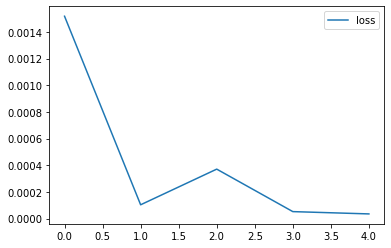

In [30]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Evaluate on Test Data

The evaluate the test data, the last point of the train data must be taken to evaluate/forcast the first point of the test data.

In [31]:
first_eval_batch = scaled_train[-length:]

In [32]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [33]:
model.predict(first_eval_batch)[0].item()

1/1 [==============================] - 0s 302ms/step


0.941798746585846

In [34]:
scaled_test[0]

array([0.94955134])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

How the for loop will work

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [36]:
current_batch.shape

(1, 50, 1)

In [37]:
current_batch

array([[[8.37405820e-01],
        [7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.5

In [38]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

With this code, the first value is dropped and the evaluated point is added to the current batch, used for the prediction

----

In [39]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred) 
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [40]:
test_predictions

[array([0.94179875], dtype=float32),
 array([0.95793337], dtype=float32),
 array([0.97017354], dtype=float32),
 array([0.9777941], dtype=float32),
 array([0.9801438], dtype=float32),
 array([0.977475], dtype=float32),
 array([0.97090536], dtype=float32),
 array([0.95915556], dtype=float32),
 array([0.94387805], dtype=float32),
 array([0.9244669], dtype=float32),
 array([0.90165365], dtype=float32),
 array([0.8748362], dtype=float32),
 array([0.8451274], dtype=float32),
 array([0.81177926], dtype=float32),
 array([0.7763462], dtype=float32),
 array([0.7380281], dtype=float32),
 array([0.6977237], dtype=float32),
 array([0.65538144], dtype=float32),
 array([0.61185795], dtype=float32),
 array([0.5665895], dtype=float32),
 array([0.52009505], dtype=float32),
 array([0.47331238], dtype=float32),
 array([0.4257628], dtype=float32),
 array([0.3781745], dtype=float32),
 array([0.33041683], dtype=float32),
 array([0.28378633], dtype=float32),
 array([0.23858435], dtype=float32),
 array([0.1947

In [41]:
scaled_test

array([[9.49551344e-01],
       [9.69156618e-01],
       [9.84074225e-01],
       [9.94155114e-01],
       [9.99298559e-01],
       [9.99453170e-01],
       [9.94617400e-01],
       [9.84839568e-01],
       [9.70217371e-01],
       [9.50896908e-01],
       [9.27071224e-01],
       [8.98978376e-01],
       [8.66899060e-01],
       [8.31153800e-01],
       [7.92099752e-01],
       [7.50127132e-01],
       [7.05655314e-01],
       [6.59128649e-01],
       [6.11012013e-01],
       [5.61786173e-01],
       [5.11942978e-01],
       [4.61980443e-01],
       [4.12397778e-01],
       [3.63690397e-01],
       [3.16344967e-01],
       [2.70834550e-01],
       [2.27613868e-01],
       [1.87114770e-01],
       [1.49741909e-01],
       [1.15868702e-01],
       [8.58335998e-02],
       [5.99367021e-02],
       [3.84367625e-02],
       [2.15486014e-02],
       [9.44095974e-03],
       [2.23481297e-03],
       [2.16257798e-06],
       [2.76531647e-03],
       [1.04966661e-02],
       [2.31189624e-02],


#### Inverse Transformations and Compare

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 0.88359217],
       [ 0.91586115],
       [ 0.9403413 ],
       [ 0.95558232],
       [ 0.96028163],
       [ 0.95494408],
       [ 0.94180494],
       [ 0.91830552],
       [ 0.88775075],
       [ 0.84892877],
       [ 0.80330262],
       [ 0.74966816],
       [ 0.69025104],
       [ 0.62355529],
       [ 0.55268975],
       [ 0.47605417],
       [ 0.39544597],
       [ 0.31076216],
       [ 0.22371587],
       [ 0.13317965],
       [ 0.04019155],
       [-0.05337305],
       [-0.14847144],
       [-0.24364725],
       [-0.33916185],
       [-0.43242211],
       [-0.52282533],
       [-0.61041824],
       [-0.69387102],
       [-0.77202156],
       [-0.84394225],
       [-0.90857774],
       [-0.96517601],
       [-1.013862  ],
       [-1.05436652],
       [-1.0856153 ],
       [-1.10735409],
       [-1.12081225],
       [-1.125016  ],
       [-1.12016384],
       [-1.10674373],
       [-1.08479394],
       [-1.05409252],
       [-1.01498332],
       [-0.96829687],
       [-0

In [43]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13240\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [44]:
test.head()

,Sine,Predictions
45.1,0.899097,0.883592
45.2,0.938307,0.915861
45.3,0.968142,0.940341
45.4,0.988304,0.955582
45.5,0.998591,0.960282


<AxesSubplot:>

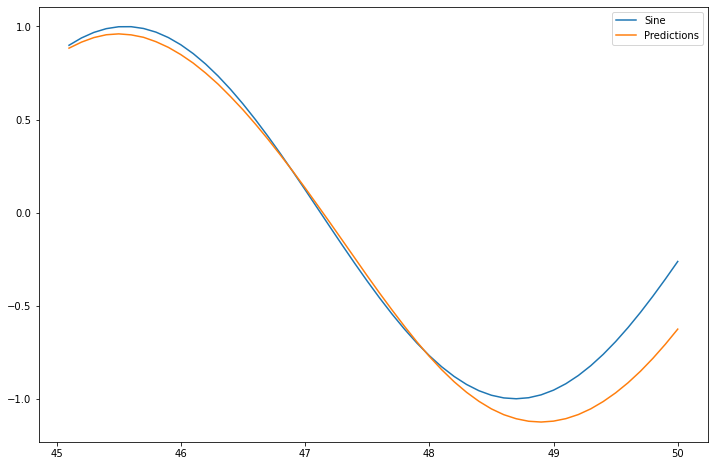

In [45]:
test.plot(figsize=(12,8))

#### Adding in Early Stopping and Validation Generator

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [50]:
# To avoid the following error:

# `start_index+length=50 > end_index=49` is disallowed, as no part of the sequence would be left to be used as current step.
# The validation generator has to be bigger than the length of batches, so the length is set 1 value smaller




length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length, batch_size=1)



### LSTMS

In [51]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [52]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13240\1950115197.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


402/402 [==============================] - 9s 16ms/step - loss: 0.0159 - val_loss: 5.0211e-05
Epoch 2/20
402/402 [==============================] - 6s 15ms/step - loss: 1.7254e-04 - val_loss: 8.0655e-06
Epoch 3/20
402/402 [==============================] - 19s 47ms/step - loss: 1.6927e-04 - val_loss: 1.1279e-04
Epoch 4/20
402/402 [==============================] - 15s 38ms/step - loss: 5.8541e-04 - val_loss: 1.4235e-05


In [53]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 35ms/step


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13240\1584625205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<AxesSubplot:>

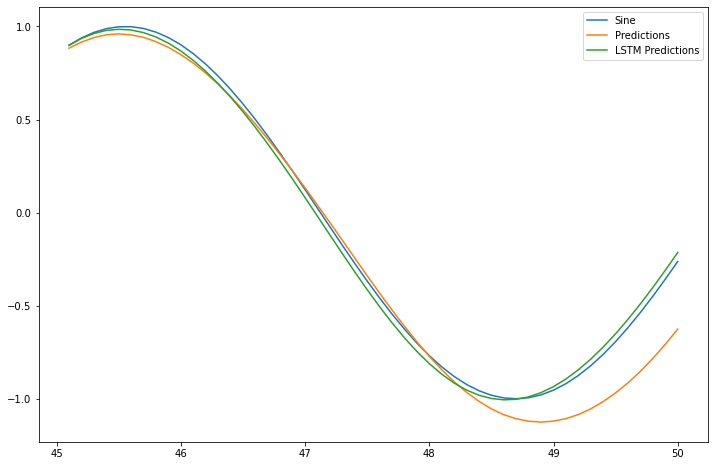

In [54]:
# IGNORE WARNINGS
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

### Forecasting

Forecast into unknown range. We should first utilize all our data, since we are now forecasting!

In [55]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [56]:
length = 100 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [57]:
model = Sequential()
model.add(LSTM(100, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13240\2826596168.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


401/401 [==============================] - 14s 29ms/step - loss: 0.0088
Epoch 2/6
401/401 [==============================] - 33s 82ms/step - loss: 8.9107e-04
Epoch 3/6
401/401 [==============================] - 33s 82ms/step - loss: 7.1285e-05
Epoch 4/6
401/401 [==============================] - 32s 79ms/step - loss: 7.0447e-05
Epoch 5/6
401/401 [==============================] - 32s 81ms/step - loss: 8.1483e-05
Epoch 6/6
401/401 [==============================] - 32s 80ms/step - loss: 2.3950e-04


In [58]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(100):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 39ms/step


In [59]:
forecast = scaler.inverse_transform(forecast)

In [62]:
100*0.1

10.0

In [63]:
forecast_index = np.arange(50.1,60.1,step=0.1)

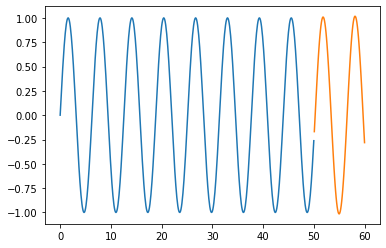

In [64]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)